# Train a Mini Auto Pilot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from keras import models , layers , optimizers , losses , metrics
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

2025-05-02 22:58:54.946415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 22:58:54.959937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746197934.972020    3193 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746197934.975235    3193 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746197934.983650    3193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Load the dataset
X = np.load('x.npy')
y = np.load('y.npy')

print(X.shape)
print(y.shape)

(125, 5, 240, 320, 1)
(125,)


In [3]:
label = y

label

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 2., 2., 0., 2., 1., 1., 1., 1., 1., 2., 1., 2.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

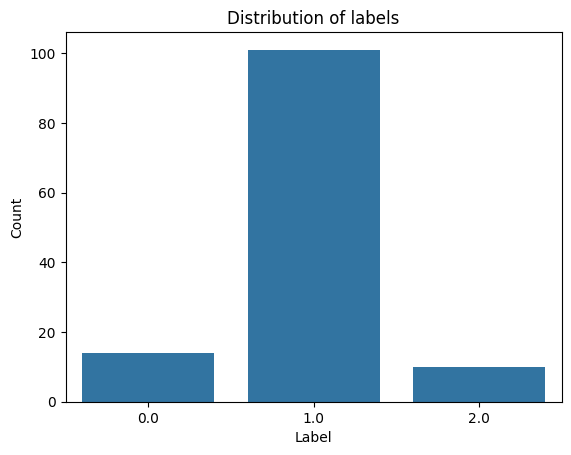

In [4]:
# distribution of label
sns.countplot(x=label)
plt.title('Distribution of labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


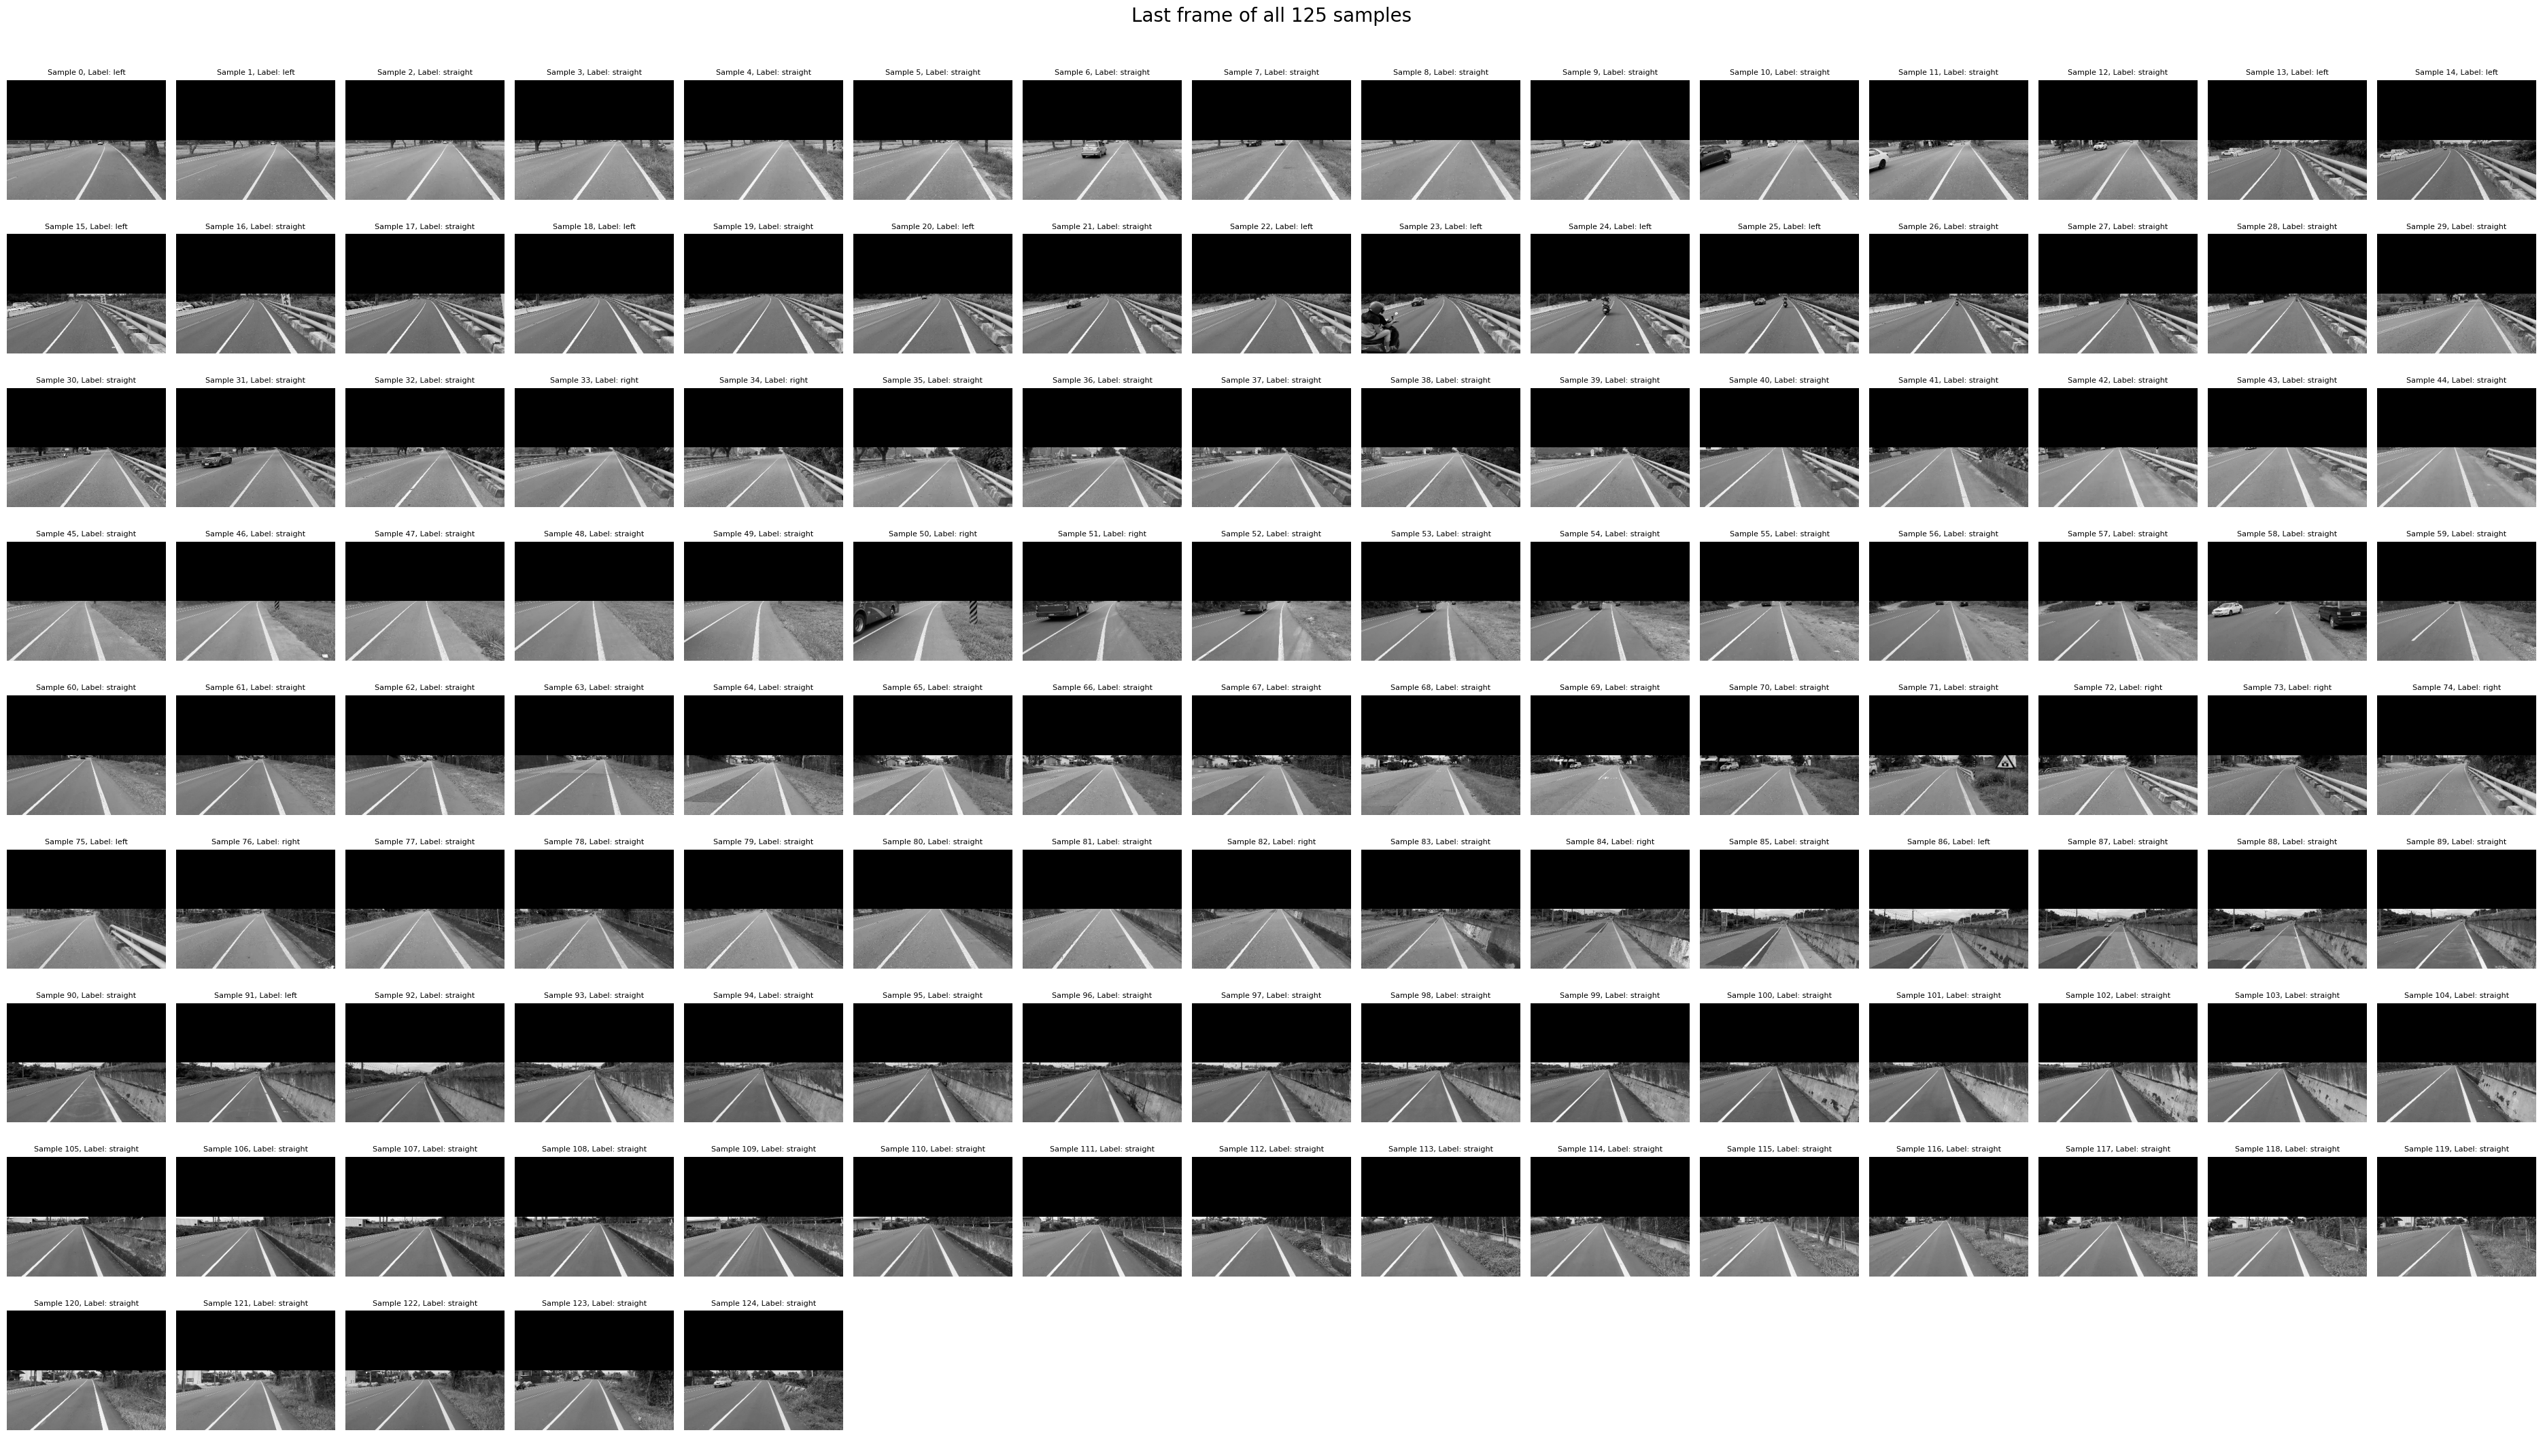

In [5]:
# plot some of the graphs in X
num_samples = len(X)
cols = 15 # Adjust number of columns as desired
rows = int(np.ceil(num_samples / cols))

# Adjust figsize based on the number of rows and columns to make plots visible
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5)) # Increased figsize per subplot
fig.suptitle(f"Last frame of all {num_samples} samples", fontsize=20) # Updated title

label_mapping = {0: "left", 1: "straight", 2: "right"}

# Flatten axes array for easy iteration, handle cases with single row/column
if rows == 1 and cols == 1:
    axes_flat = [axes]
elif rows == 1 or cols == 1:
    axes_flat = axes
else:
    axes_flat = axes.flatten()


for i, ax in enumerate(axes_flat):
    if i < num_samples:  # Iterate through all samples
        frame_to_show = X[i, 4].squeeze()
        ax.imshow(frame_to_show, cmap='gray')
        # Reduced font size for potentially many plots
        ax.set_title(f"Sample {i}, Label: {label_mapping[label[i]]}", fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off') # Hide axes for empty subplots if grid is larger than num_samples

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout
plt.show()


Found 10 samples with label 'right'.


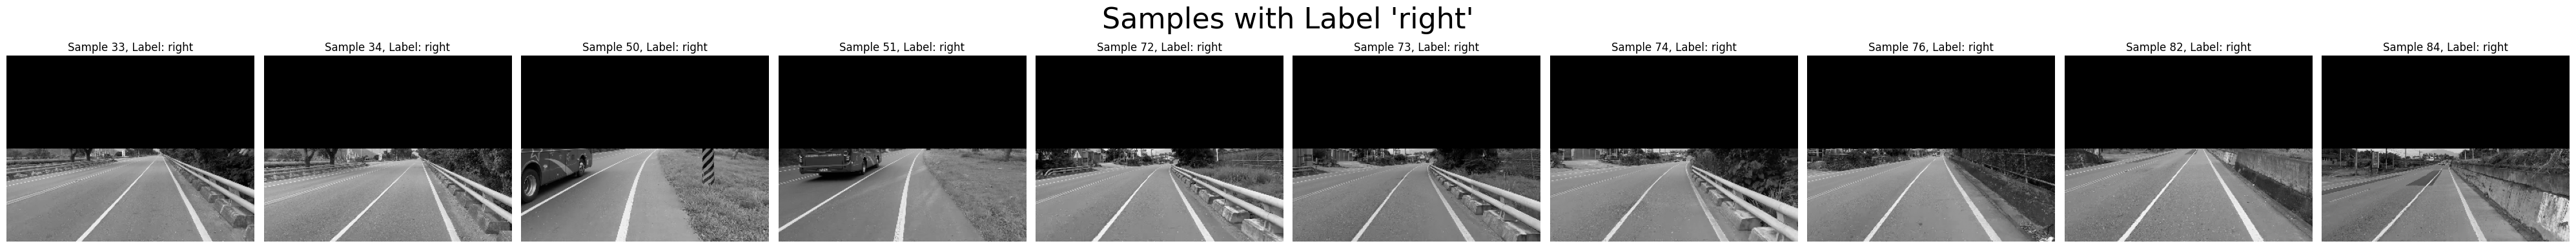

In [6]:
right_indices = np.where(label == 2)[0]
num_right_samples = len(right_indices)

print(f"Found {num_right_samples} samples with label 'right'.")

# Determine grid size for plotting
cols = 10 # Number of columns in the plot grid
rows = int(np.ceil(num_right_samples / cols)) # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4)) # Adjust figsize as needed
fig.suptitle("Samples with Label 'right'", fontsize=32)

# Flatten axes array for easy iteration, handle case where there's only one row/column
if rows == 1 and cols == 1:
    axes_flat = [axes]
elif rows == 1 or cols == 1:
     axes_flat = axes
else:
    axes_flat = axes.flatten()


for i, idx in enumerate(right_indices):
    if i < len(axes_flat): # Ensure we don't plot more images than subplots
        ax = axes_flat[i]
        frame_to_show = X[idx, 4].squeeze()  # Get the last frame of the sequence
        ax.imshow(frame_to_show, cmap='gray')
        ax.set_title(f"Sample {idx}, Label: right", fontsize=12) # Show original index
        ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

<b>Solve class imbalance problem

In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label),
    y=label
)
print("Class weights:", class_weights)
class_weights_dict = dict(enumerate(class_weights))

Class weights: [2.97619048 0.41254125 4.16666667]


## Construct model

In [8]:
def get_model():
    input_layer = layers.Input(shape=(5, 240, 320, 1))

    # ----- Branch 1: Temporal convolution across 5 frames -----
    branch1 = layers.Conv3D(16, (3, 5, 5), activation='relu', padding='same')(input_layer)
    branch1 = layers.MaxPooling3D((1, 2, 2))(branch1)
    branch1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(branch1)
    branch1 = layers.MaxPooling3D((1, 2, 2))(branch1)
    branch1 = layers.MaxPooling3D((2, 1, 1))(branch1)
    branch1 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(branch1)
    branch1 = layers.MaxPooling3D((1, 2, 2))(branch1)
    branch1 = layers.Conv3D(128, (5, 3, 3), activation='relu', padding='same')(branch1)
    branch1 = layers.GlobalAveragePooling3D()(branch1)

    # ----- Branch 2: Only the last frame -----
    last_frame = layers.Cropping3D(cropping=((4, 0), (0, 0), (0, 0)))(input_layer)
    last_frame = layers.Lambda(lambda x: x[:, 0, :, :, :])(last_frame)
    branch2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(last_frame)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)
    branch2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(branch2)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)
    branch2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(branch2)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)
    branch2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(branch2)
    branch2 = layers.GlobalAveragePooling2D()(branch2)

    # ----- Merge and Final Layers -----
    merged = layers.concatenate([branch1, branch2])
    output = layers.Dense(256)(merged)
    output = layers.BatchNormalization()(output)
    output = layers.Activation('relu')(output)
    output = layers.Dropout(0.3)(output)
    output = layers.Dense(128)(output)
    output = layers.BatchNormalization()(output)
    output = layers.Activation('relu')(output)
    output = layers.Dropout(0.2)(output)
    output = layers.Dense(64, activation='relu')(output)
    output = layers.Dense(32, activation='relu')(output)
    output = layers.Dense(3, activation='softmax')(output)

    model = models.Model(inputs=input_layer, outputs=output)

    return model

In [9]:
model = get_model()
model.summary()

I0000 00:00:1746197978.267976    3193 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 240,    │          0 │ -                 │
│ (InputLayer)        │ 320, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping3d          │ (None, 1, 240,    │          0 │ input_layer[0][0] │
│ (Cropping3D)        │ 320, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 5, 240,    │      1,216 │ input_layer[0][0] │
│                     │ 320, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 240, 320,  │          0 │ cropping3d[0][0]  │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 5, 120,    │          0 │ conv3d[0][0]      │
│ (MaxPooling3D)      │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 240, 320,  │        832 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 120,    │     13,856 │ max_pooling3d[0]… │
│                     │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 120, 160,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 5, 60, 80, │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 120, 160,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 2, 60, 80, │          0 │ max_pooling3d_1[… │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 60, 80,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 2, 60, 80, │     55,360 │ max_pooling3d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 80,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 2, 30, 40, │          0 │ conv3d_2[0][0]    │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 30, 40,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 2, 30, 40, │    368,768 │ max_pooling3d_3[

 Total params: 970,979 (3.70 MB)

 Trainable params: 970,211 (3.70 MB)

 Non-trainable params: 768 (3.00 KB)

In [10]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
]

In [12]:
history = model.fit(
    X,
    label,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    shuffle=True,
    verbose=1
)

Epoch 1/50


I0000 00:00:1746197981.290828    3992 service.cc:152] XLA service 0x7f7b3801bf70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746197981.290870    3992 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-02 22:59:41.336026: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746197981.701611    3992 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-02 22:59:42.841605: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2524', 48 bytes spill stores, 48 bytes spill loads

2025-05-02 22:59:44.043746: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.1128 - loss: 1.4081

2025-05-02 23:00:08.977669: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-02 23:00:09.083991: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-02 23:00:09.180385: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-02 23:00:09.274977: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1171 - loss: 1.3970   

2025-05-02 23:00:17.563963: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-02 23:00:17.683179: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.1197 - loss: 1.3904 - val_accuracy: 0.0000e+00 - val_loss: 4.5133 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.3381 - loss: 1.1931 - val_accuracy: 1.0000 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.4196 - loss: 1.1776 - val_accuracy: 1.0000 - val_loss: 1.5259e-07 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.4938 - loss: 1.2498 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.5059 - loss: 1.1756 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.3841 - loss: 1.1615 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.3638 - loss: 1.2920 - val_acc

In [14]:
model.save("COMP2211_PA2_Mini_AutoPilot.keras")

### Plot Training Process

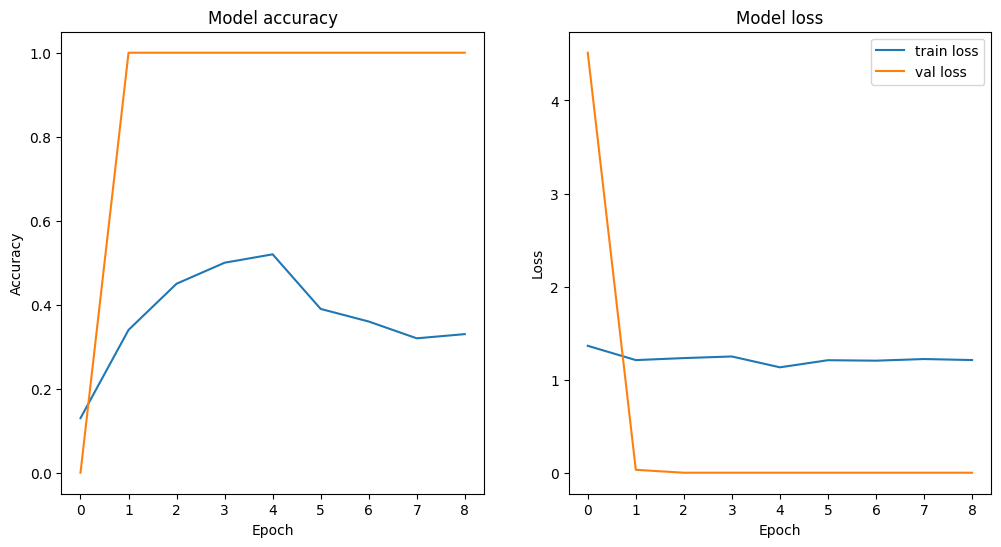

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()
